In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import re
import glob
import codecs
import pathlib

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import utils

In [2]:
sources_files = utils.get_sources_files()
text_folders = utils.get_text_folders()

print("Number of Sources Files: ", len(sources_files))
print("Number of Text Folders: ", len(text_folders))

Number of Sources Files:  49
Number of Text Folders:  129


In [3]:
%%time

summary_stats, file_lookup = [], []
current_year, current_month = None, None
for i, sources_file in enumerate(sources_files, 1): 
    print(f"Source file ({i:>02}/{len(sources_files):>02}): {sources_file}... ", end="", flush=True)
    
    sources = utils.read_sources_file(sources_file)
    sources["month"] = sources["date"].dt.month
    sources["year"] = sources["date"].dt.year
    
    sources_groups = sources.groupby(["year", "month", "country"])
    for (year, month, country), df in sources_groups:
        success = True
        if (
            sources["year"].unique().shape[0] > 1 and
            (year != current_year or month != current_month)
        ):
            print(f"\n  {utils.format_year(year)}-{utils.format_month(month)}: ", end="", flush=True)
            current_year, current_month = year, month
            
        print(country, end=", ", flush=True)
        summary_stats.append((year, month, country, *utils.get_basic_summary_stats(df)))
        
        try:
            text_file_path = utils.get_text_file_path(text_folders, year, month, country)
        except:
            text_file_path = None
            success = False
            
        if text_file_path:
            try:
                articles = df.merge(utils.read_text_file(text_file_path), on="id", how="outer")
                articles.apply(utils.export_report, axis=1, path=utils.CLEAN_DATA_FOLDER)
            except:
                success = False
        
        file_lookup.append((year, month, country, sources_file, text_file_path, success))
    
    print()
    
summary_stats_df = pd.DataFrame(summary_stats, columns=["year", "month", "country", "num_sources", "num_articles", "total_words"])
summary_stats_df.to_csv("summary_stats.csv", index=False)

file_lookup_df = pd.DataFrame(file_lookup, columns=["year", "month", "country", "source_file", "text_file", "success"])
file_lookup_df.to_csv("file_lookup.csv", index=False)

Source file (01/49): data\raw\now_sources_pt1.txt... 
  10-01: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-02: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-03: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-04: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, US, ZA, 
  10-05: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-06: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-07: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, US, ZA, 
  10-08: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-09: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, US, ZA, 
  10-10: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-11: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, N

OSError: [Errno 28] No space left on device

In [9]:
summary_stats_df = pd.DataFrame(summary_stats, columns=["year", "month", "country", "num_sources", "num_articles", "total_words"])
summary_stats_df.to_csv("data/summary_stats.csv", index=False)

file_lookup_df = pd.DataFrame(file_lookup, columns=["year", "month", "country", "source_file", "text_file", "success"])
file_lookup_df.to_csv("data/file_lookup.csv", index=False)

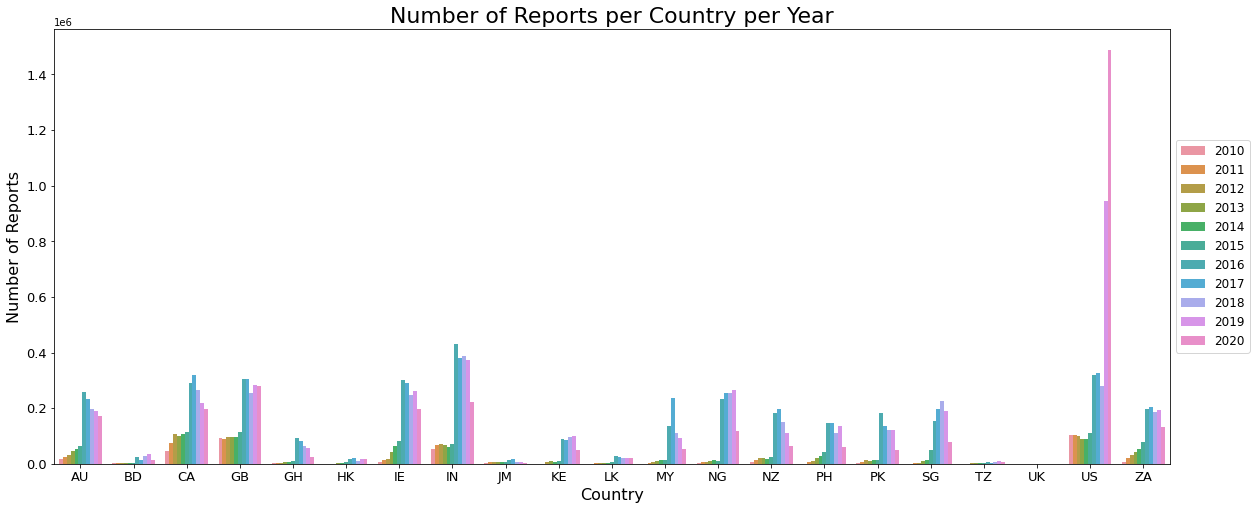

In [5]:
summary_by_country_by_year = summary_stats_df.groupby(["country", "year"])
summary_by_country_by_year = summary_by_country_by_year[["num_sources", "num_articles", "total_words"]]
summary_by_country_by_year = summary_by_country_by_year.sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="num_articles", 
    hue="year",
    data=summary_by_country_by_year,
    ax=ax
)

ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Reports", fontsize=16)
ax.set_title("Number of Reports per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

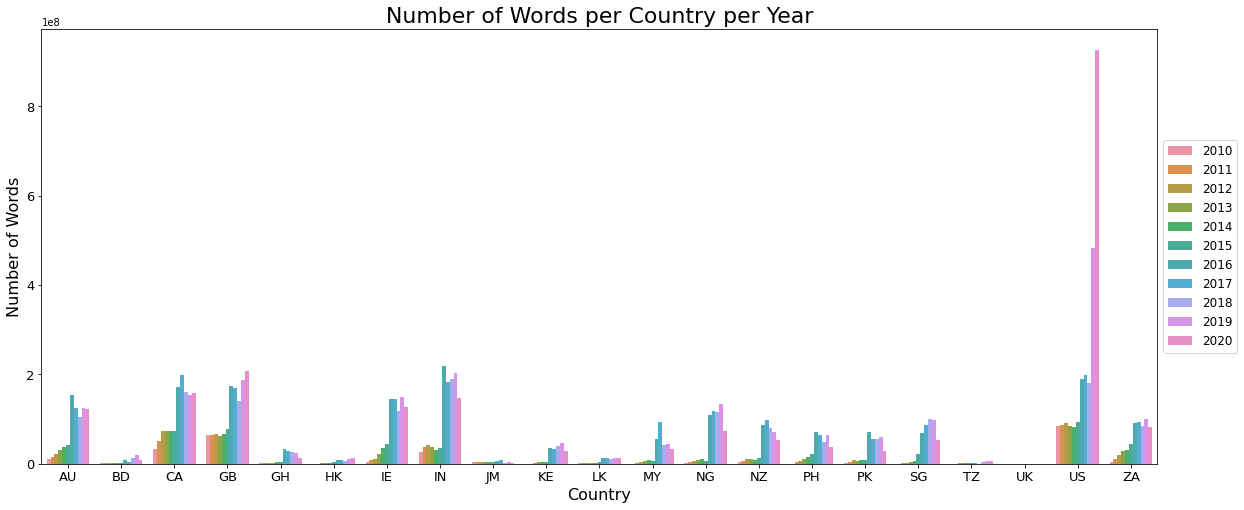

In [6]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="total_words", 
    hue="year",
    data=summary_by_country_by_year,
    ax=ax
)
ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Words", fontsize=16)
ax.set_title("Number of Words per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);